In [1]:
import time
import numpy as np
import pandas as pd

from scipy import sparse
from scipy.stats.mstats import gmean
from datetime import datetime
from sklearn import preprocessing
from scipy.stats import skew, boxcox,boxcox_normmax
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from bayes_opt import BayesianOptimization
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb

seed = 1234

/home/xujin/AI/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Data

In [2]:
train_y = np.ravel(pd.read_csv('../input/' + 'labels_BrandenMurray.csv'))

names = ['low_0','medium_0','high_0',
        'low_1','medium_1','high_1',
        'low_2','medium_2','high_2',
        'low_3','medium_3','high_3',
        'low_4','medium_4','high_4',
        'low_5','medium_5','high_5',
        'low_6','medium_6','high_6',
        'low_7','medium_7','high_7',
        'low_8','medium_8','high_8',
        'low_9','medium_9','high_9']

data_path = "../blend/"

In [3]:
# RFC 1st level
file_train      = 'train_blend_RFC_gini_BM_MB_add03052240_2017-03-10-22-02' + '.csv'
file_test_mean  = 'test_blend_RFC_gini_mean_BM_MB_add03052240_2017-03-10-22-02' + '.csv'
file_test_gmean = 'test_blend_RFC_gini_gmean_BM_MB_add03052240_2017-03-10-22-02' + '.csv'

train_rfc_gini      = pd.read_csv(data_path + file_train,      header = None)
test_rfc_gini_mean  = pd.read_csv(data_path + file_test_mean,  header = None)
test_rfc_gini_gmean = pd.read_csv(data_path + file_test_gmean, header = None)

n_column = train_rfc_gini.shape[1]

train_rfc_gini.columns      = ['rfc_gini_' + x for x in names[:n_column]]
test_rfc_gini_mean.columns  = ['rfc_gini_' + x for x in names[:n_column]]
test_rfc_gini_gmean.columns = ['rfc_gini_' + x for x in names[:n_column]]

file_train      = 'train_blend_RFC_entropy_BM_MB_add03052240_2017-03-10-21-10' + '.csv'
file_test_mean  = 'test_blend_RFC_entropy_mean_BM_MB_add03052240_2017-03-10-21-10' + '.csv'
file_test_gmean = 'test_blend_RFC_entropy_gmean_BM_MB_add03052240_2017-03-10-21-10' + '.csv'

train_rfc_entropy      = pd.read_csv(data_path + file_train,      header = None)
test_rfc_entropy_mean  = pd.read_csv(data_path + file_test_mean,  header = None)
test_rfc_entropy_gmean = pd.read_csv(data_path + file_test_gmean, header = None)

n_column = train_rfc_entropy.shape[1]

train_rfc_entropy.columns      = ['rfc_entropy_' + x for x in names[:n_column]]
test_rfc_entropy_mean.columns  = ['rfc_entropy_' + x for x in names[:n_column]]
test_rfc_entropy_gmean.columns = ['rfc_entropy_' + x for x in names[:n_column]]

print 'train_rfc_gini: {}\t test_rfc_gini_mean:{}\t test_rfc_gini_gmean:{}'.\
        format(train_rfc_gini.shape,test_rfc_gini_mean.shape,test_rfc_gini_gmean.shape)
print '\ntrain_rfc_entropy: {}\t test_rfc_entropy_mean:{}\t test_rfc_entropy_gmean:{}'.\
        format(train_rfc_entropy.shape,test_rfc_entropy_mean.shape,test_rfc_entropy_gmean.shape)

print '\ntrain_rfc_gini'
print train_rfc_gini.iloc[:5,:3]
print '\ntrain_rfc_entropy'
print train_rfc_entropy.iloc[:5,:3]

train_rfc_gini: (49352, 3)	 test_rfc_gini_mean:(74659, 3)	 test_rfc_gini_gmean:(74659, 3)

train_rfc_entropy: (49352, 3)	 test_rfc_entropy_mean:(74659, 3)	 test_rfc_entropy_gmean:(74659, 3)

train_rfc_gini
   rfc_gini_low_0  rfc_gini_medium_0  rfc_gini_high_0
0        0.543090           0.387824         0.069086
1        0.431967           0.501843         0.066191
2        0.796826           0.180090         0.023085
3        0.671667           0.274519         0.053815
4        0.931788           0.064494         0.003718

train_rfc_entropy
   rfc_entropy_low_0  rfc_entropy_medium_0  rfc_entropy_high_0
0           0.542659              0.393322            0.064019
1           0.464249              0.477816            0.057935
2           0.799674              0.184329            0.015997
3           0.686509              0.278618            0.034872
4           0.966726              0.029282            0.003992


In [4]:
# LR 1st level
file_train = 'train_blend_LR_BM_2017-03-09-02-38' + '.csv'
file_test_mean = 'test_blend_LR_mean_BM_2017-03-09-02-38' + '.csv'
file_test_gmean = 'test_blend_LR_gmean_BM_2017-03-09-02-38' + '.csv'

train_LR      = pd.read_csv(data_path + file_train, header = None)
test_LR_mean  = pd.read_csv(data_path + file_test_mean, header = None)
test_LR_gmean = pd.read_csv(data_path + file_test_gmean, header = None)

n_column = train_LR.shape[1]

train_LR.columns      = ['LR_' + x for x in names[:n_column]]
test_LR_mean.columns  = ['LR_' + x for x in names[:n_column]]
test_LR_gmean.columns = ['LR_' + x for x in names[:n_column]]


fe_useful = ['LR_low_0', 'LR_medium_0', 'LR_high_0', 
             'LR_low_1', 'LR_medium_1', 'LR_high_1', 
#              'LR_low_2', 'LR_medium_2', 'LR_high_2', 
             'LR_low_3', 'LR_medium_3', 'LR_high_3', 
             'LR_low_4', 'LR_medium_4', 'LR_high_4',
             'LR_low_5', 'LR_medium_5', 'LR_high_5', 
#              'LR_low_6', 'LR_medium_6','LR_high_6'
            ]
# del LR_6 
# del LR_2
train_LR      = train_LR[fe_useful]
test_LR_mean  = test_LR_mean[fe_useful]
test_LR_gmean = test_LR_gmean[fe_useful]





print 'train_LR: {}\t test_LR_mean:{}\t test_LR_gmean:{}'.\
        format(train_LR.shape,test_LR_mean.shape,test_LR_gmean.shape)

print '\ntrain_LR'
print train_LR.iloc[:5,:3]




train_LR: (49352, 15)	 test_LR_mean:(74659, 15)	 test_LR_gmean:(74659, 15)

train_LR
   LR_low_0  LR_medium_0  LR_high_0
0  0.422874     0.486259   0.090867
1  0.321009     0.599539   0.079452
2  0.655066     0.315023   0.029912
3  0.711200     0.252680   0.036120
4  0.902499     0.090717   0.006784


In [5]:
# ET 1st level
file_train      = 'train_blend_ET_gini_BM_2017-03-10-09-42' + '.csv'
file_test_mean  = 'test_blend_ET_gini_mean_BM_2017-03-10-09-42' + '.csv'
file_test_gmean = 'test_blend_ET_gini_gmean_BM_2017-03-10-09-42' + '.csv'

train_ET_gini      = pd.read_csv(data_path + file_train,      header = None)
test_ET_gini_mean  = pd.read_csv(data_path + file_test_mean,  header = None)
test_ET_gini_gmean = pd.read_csv(data_path + file_test_gmean, header = None)

n_column = train_ET_gini.shape[1]

train_ET_gini.columns      = ['ET_gini_' + x for x in names[:n_column]]
test_ET_gini_mean.columns  = ['ET_gini_' + x for x in names[:n_column]]
test_ET_gini_gmean.columns = ['ET_gini_' + x for x in names[:n_column]]

file_train      = 'train_blend_ET_entropy_BM_2017-03-09-20-44' + '.csv'
file_test_mean  = 'test_blend_ET_entropy_mean_BM_2017-03-09-20-44' + '.csv'
file_test_gmean = 'test_blend_ET_entropy_gmean_BM_2017-03-09-20-44' + '.csv'

train_ET_entropy      = pd.read_csv(data_path + file_train,      header = None)
test_ET_entropy_mean  = pd.read_csv(data_path + file_test_mean,  header = None)
test_ET_entropy_gmean = pd.read_csv(data_path + file_test_gmean, header = None)

n_column = train_ET_entropy.shape[1]

train_ET_entropy.columns      = ['ET_entropy_' + x for x in names[:n_column]]
test_ET_entropy_mean.columns  = ['ET_entropy_' + x for x in names[:n_column]]
test_ET_entropy_gmean.columns = ['ET_entropy_' + x for x in names[:n_column]]

print 'train_ET_gini: {}\t test_ET_gini_mean:{}\t test_ET_gini_gmean:{}'.\
        format(train_ET_gini.shape,test_ET_gini_mean.shape,test_ET_gini_gmean.shape)
print '\ntrain_ET_entropy: {}\t test_ET_entropy_mean:{}\t test_ET_entropy_gmean:{}'.\
        format(train_ET_entropy.shape,test_ET_entropy_mean.shape,test_ET_entropy_gmean.shape)
    
    
print '\ntrain_ET_gini'
print train_ET_gini.iloc[:5,:3]
print '\ntrain_ET_entropy'
print train_ET_entropy.iloc[:5,:3]

train_ET_gini: (49352, 3)	 test_ET_gini_mean:(74659, 3)	 test_ET_gini_gmean:(74659, 3)

train_ET_entropy: (49352, 3)	 test_ET_entropy_mean:(74659, 3)	 test_ET_entropy_gmean:(74659, 3)

train_ET_gini
   ET_gini_low_0  ET_gini_medium_0  ET_gini_high_0
0       0.491197          0.458682        0.050121
1       0.350925          0.570142        0.078934
2       0.834381          0.154016        0.011603
3       0.721964          0.239236        0.038800
4       0.950719          0.042887        0.006394

train_ET_entropy
   ET_entropy_low_0  ET_entropy_medium_0  ET_entropy_high_0
0          0.520529             0.431357           0.048114
1          0.377125             0.551815           0.071060
2          0.799234             0.188755           0.012011
3          0.716421             0.248984           0.034595
4          0.925534             0.066681           0.007785


In [6]:
# KNN 1st level
file_train      = 'train_blend_KNN_uniform_BM_MB_add03052240_2017-03-11-18-31' + '.csv'
file_test_mean  = 'test_blend_KNN_uniform_mean_BM_MB_add03052240_2017-03-11-18-31' + '.csv'
file_test_gmean = 'test_blend_KNN_uniform_gmean_BM_MB_add03052240_2017-03-11-18-31' + '.csv'

train_KNN_uniform      = pd.read_csv(data_path + file_train,      header = None)
test_KNN_uniform_mean  = pd.read_csv(data_path + file_test_mean,  header = None)
test_KNN_uniform_gmean = pd.read_csv(data_path + file_test_gmean, header = None)

n_column = train_KNN_uniform.shape[1]

train_KNN_uniform.columns      = ['KNN_uniform_' + x for x in names[:n_column]]
test_KNN_uniform_mean.columns  = ['KNN_uniform_' + x for x in names[:n_column]]
test_KNN_uniform_gmean.columns = ['KNN_uniform_' + x for x in names[:n_column]]

file_train      = 'train_blend_KNN_distance_BM_MB_add_2017-03-11-21-51' + '.csv'
file_test_mean  = 'test_blend_KNN_distance_mean_BM_MB_add_2017-03-11-21-51' + '.csv'
file_test_gmean = 'test_blend_KNN_distance_gmean_BM_MB_add_2017-03-11-21-51' + '.csv'

train_KNN_distance      = pd.read_csv(data_path + file_train,      header = None)
test_KNN_distance_mean  = pd.read_csv(data_path + file_test_mean,  header = None)
test_KNN_distance_gmean = pd.read_csv(data_path + file_test_gmean, header = None)

n_column = train_KNN_distance.shape[1]

train_KNN_distance.columns      = ['KNN_distance_' + x for x in names[:n_column]]
test_KNN_distance_mean.columns  = ['KNN_distance_' + x for x in names[:n_column]]
test_KNN_distance_gmean.columns = ['KNN_distance_' + x for x in names[:n_column]]

print 'train_KNN_uniform: {}\t test_KNN_uniform_mean:{}\t test_KNN_uniform_gmean:{}'.\
        format(train_KNN_uniform.shape,test_KNN_uniform_mean.shape,test_KNN_uniform_gmean.shape)
print '\ntrain_KNN_distance: {}\t test_KNN_distance_mean:{}\t test_KNN_distance_gmean:{}'.\
        format(train_KNN_distance.shape,test_KNN_distance_mean.shape,test_KNN_distance_gmean.shape)
    
print '\ntrain_KNN_uniform'
print train_KNN_uniform.iloc[:5,:3]
print '\ntrain_KNN_distance'
print train_KNN_distance.iloc[:5,:3]

train_KNN_uniform: (49352, 3)	 test_KNN_uniform_mean:(74659, 3)	 test_KNN_uniform_gmean:(74659, 3)

train_KNN_distance: (49352, 3)	 test_KNN_distance_mean:(74659, 3)	 test_KNN_distance_gmean:(74659, 3)

train_KNN_uniform
   KNN_uniform_low_0  KNN_uniform_medium_0  KNN_uniform_high_0
0              0.505                 0.390               0.105
1              0.535                 0.355               0.110
2              0.675                 0.270               0.055
3              0.555                 0.295               0.150
4              0.815                 0.155               0.030

train_KNN_distance
   KNN_distance_low_0  KNN_distance_medium_0  KNN_distance_high_0
0            0.540803               0.380577             0.078620
1            0.540929               0.347829             0.111242
2            0.666872               0.280763             0.052364
3            0.575852               0.266448             0.157700
4            0.845119               0.142102       

In [7]:
# TFFM 1st level
file_train      = 'train_blend_FM_BM_MB_add_desc_2017-03-16-09-52' + '.csv'
file_test_mean  = 'test_blend_FM_mean_BM_MB_add_desc_2017-03-16-09-52' + '.csv'
file_test_gmean = 'test_blend_FM_gmean_BM_MB_add_desc_2017-03-16-09-52' + '.csv'

train_FM      = pd.read_csv(data_path + file_train,      header = None)
test_FM_mean  = pd.read_csv(data_path + file_test_mean,  header = None)
test_FM_gmean = pd.read_csv(data_path + file_test_gmean, header = None)

n_column = train_FM.shape[1]

train_FM.columns      = ['FM_' + x for x in names[:n_column]]
test_FM_mean.columns  = ['FM_' + x for x in names[:n_column]]
test_FM_gmean.columns = ['FM_' + x for x in names[:n_column]]

print 'train_FM: {}\t test_FM_mean:{}\t test_FM_gmean:{}'.\
        format(train_FM.shape,test_FM_mean.shape,test_FM_gmean.shape)

print '\ntrain_FM'
print train_FM.iloc[:5,:3]

train_FM: (49352, 3)	 test_FM_mean:(74659, 3)	 test_FM_gmean:(74659, 3)

train_FM
   FM_low_0  FM_medium_0  FM_high_0
0  0.458595     0.410776   0.130629
1  0.329965     0.537926   0.132109
2  0.767341     0.206732   0.025927
3  0.617983     0.351273   0.030744
4  0.877894     0.103967   0.018139


In [8]:
# Multinomial Naive Bayes 1st level
file_train      = 'train_blend_MNB_BM_MB_add03052240_2017-03-13-20-51' + '.csv'
file_test_mean  = 'test_blend_MNB_mean_BM_MB_add03052240_2017-03-13-20-51' + '.csv'
file_test_gmean = 'test_blend_MNB_gmean_BM_MB_add03052240_2017-03-13-20-51' + '.csv'

train_MNB      = pd.read_csv(data_path + file_train,      header = None)
test_MNB_mean  = pd.read_csv(data_path + file_test_mean,  header = None)
test_MNB_gmean = pd.read_csv(data_path + file_test_gmean, header = None)

n_column = train_MNB.shape[1]

train_MNB.columns      = ['MNB_' + x for x in names[:n_column]]
test_MNB_mean.columns  = ['MNB_' + x for x in names[:n_column]]
test_MNB_gmean.columns = ['MNB_' + x for x in names[:n_column]]

print 'train_MNB: {}\t test_MNB_mean:{}\t test_MNB_gmean:{}'.\
        format(train_MNB.shape,test_MNB_mean.shape,test_MNB_gmean.shape)
    
print '\ntrain_MNB'
print train_MNB.iloc[:5,:3]

train_MNB: (49352, 9)	 test_MNB_mean:(74659, 9)	 test_MNB_gmean:(74659, 9)

train_MNB
   MNB_low_0  MNB_medium_0  MNB_high_0
0   0.250130      0.546075    0.203795
1   0.514751      0.424027    0.061222
2   0.675745      0.283239    0.041015
3   0.238787      0.331607    0.429605
4   0.909543      0.082724    0.007733


In [9]:
# TSNE 1st level

file_train = 'X_train_tsne_BM_MB_add_desc_2017-03-18-17-14' + '.csv'
file_test  = 'X_test_tsne_BM_MB_add_desc_2017-03-18-17-14' + '.csv'

train_tsne = pd.read_csv(data_path + file_train, header = None)
test_tsne  = pd.read_csv(data_path + file_test, header = None)


n_column = train_tsne.shape[1]

train_tsne.columns = ['tsne_0', 'tsne_1', 'tsne_2']
test_tsne.columns  = ['tsne_0', 'tsne_1', 'tsne_2']

print 'train_tsne: {}\t test_tsne:{}'.\
        format(train_tsne.shape,test_tsne.shape)
    
print '\ntrain_xgb'
print train_tsne.iloc[:5,:3]

train_tsne: (49352, 3)	 test_tsne:(74659, 3)

train_xgb
      tsne_0     tsne_1    tsne_2
0  -8.398991  -2.415894 -3.602143
1   0.698237   0.335786  8.884257
2  -5.811380 -16.669975  7.145837
3  -0.371861 -25.894747 -2.076309
4 -15.371799   9.656209  5.813590


In [10]:
# XGB 1st level

file_train = 'train_blend_xgb_BM_MB_add_desc_2017-03-14-16-54' + '.csv'
file_test_mean = 'test_blend_xgb_mean_BM_MB_add_desc_2017-03-14-16-54' + '.csv'
file_test_gmean = 'test_blend_xgb_gmean_BM_MB_add_desc_2017-03-14-16-54' + '.csv'

train_xgb      = pd.read_csv(data_path + file_train, header = None)
test_xgb_mean  = pd.read_csv(data_path + file_test_mean, header = None)
test_xgb_gmean = pd.read_csv(data_path + file_test_gmean, header = None)

n_column = train_xgb.shape[1]

train_xgb.columns = ['xgb_' + x for x in names[:n_column]]
test_xgb_mean.columns = ['xgb_' + x for x in names[:n_column]]
test_xgb_gmean.columns = ['xgb_' + x for x in names[:n_column]]

print 'train_xgb: {}\t test_xgb_mean:{}\t test_xgb_gmean:{}'.\
        format(train_xgb.shape,test_xgb_mean.shape,test_xgb_gmean.shape)
    
print '\ntrain_xgb'
print train_xgb.iloc[:5,:3]

train_xgb: (49352, 15)	 test_xgb_mean:(74659, 15)	 test_xgb_gmean:(74659, 15)

train_xgb
   xgb_low_0  xgb_medium_0  xgb_high_0
0   0.620867      0.354255    0.024877
1   0.430220      0.494481    0.075300
2   0.841392      0.146357    0.012251
3   0.832960      0.161299    0.005741
4   0.976559      0.022998    0.000443


In [11]:
train_2nd      = pd.concat([train_rfc_gini, train_rfc_entropy, 
                            train_LR, 
                            train_ET_gini, train_ET_entropy, 
                            train_KNN_uniform, train_KNN_distance,
                            train_FM,
                            train_MNB,
                            train_tsne,
                            train_xgb
                           ], axis = 1)

test_2nd_mean  = pd.concat([test_rfc_gini_mean,test_rfc_entropy_mean, 
                            test_LR_mean, 
                            test_ET_gini_mean, test_ET_entropy_mean,
                            test_KNN_uniform_mean, test_KNN_distance_mean, 
                            test_FM_mean,
                            test_MNB_mean,
                            test_tsne,
                            test_xgb_mean
                           ], axis = 1)

test_2nd_gmean = pd.concat([test_rfc_gini_gmean,test_rfc_entropy_gmean, 
                            test_LR_gmean, 
                            test_ET_gini_gmean, test_ET_entropy_gmean,
                            test_KNN_uniform_gmean, test_KNN_distance_gmean,
                            test_FM_gmean,
                            test_MNB_gmean,
                            test_tsne,
                            test_xgb_gmean
                           ], axis = 1)

print 'train_2nd: {}\t test_2nd_mean:{}\t test_2nd_gmean:{}'.\
            format(train_2nd.shape,test_2nd_mean.shape,test_2nd_gmean.shape)

train_2nd: (49352, 63)	 test_2nd_mean:(74659, 63)	 test_2nd_gmean:(74659, 63)


In [12]:


#Our feature construction class will inherit from these two base classes of sklearn.
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

class manager_skill(BaseEstimator, TransformerMixin):
    """
    Adds the column "manager_skill" to the dataset, based on the Kaggle kernel
    "Improve Perfomances using Manager features" by den3b. The function should
    be usable in scikit-learn pipelines.    
    Parameters
    ----------
    threshold : Minimum count of rental listings a manager must have in order
                to get his "own" score, otherwise the mean is assigned.
    Attributes
    ----------
    mapping : pandas dataframe
        contains the manager_skill per manager id.        
    mean_skill : float
        The mean skill of managers with at least as many listings as the 
        threshold.
    """
    def __init__(self, threshold = 100):        
        self.threshold = threshold        
    def _reset(self):
        """Reset internal data-dependent state of the scaler, if necessary.        
        __init__ parameters are not touched.
        """
        # Checking one attribute is enough, becase they are all set together
        # in fit        
        if hasattr(self, 'mapping_'):            
            self.mapping_ = {}
            self.mean_skill_ = 0.0        
    def fit(self, X,y):
        """Compute the skill values per manager for later use.        
        Parameters
        ----------
        X : pandas dataframe, shape [n_samples, n_features]
            The rental data. It has to contain a column named "manager_id".            
        y : pandas series or numpy array, shape [n_samples]
            The corresponding target values with encoding:
            low: 0.0
            medium: 1.0
            high: 2.0
        """        
        self._reset()        
        temp = pd.concat([X.manager_id,pd.get_dummies(y)], axis = 1).groupby('manager_id').mean()
        temp.columns = ['low_frac', 'medium_frac', 'high_frac']
        temp['count'] = X.groupby('manager_id').count().iloc[:,1]        
        print(temp.head())        
        temp['manager_skill'] = temp['high_frac']*2 + temp['medium_frac']        
        mean = temp.loc[temp['count'] >= self.threshold, 'manager_skill'].mean()        
        temp.loc[temp['count'] < self.threshold, 'manager_skill'] = mean        
        self.mapping_ = temp[['manager_skill']]
        self.mean_skill_ = mean            
        return self        
    def transform(self, X):
        """Add manager skill to a new matrix.        
        Parameters
        ----------
        X : pandas dataframe, shape [n_samples, n_features]
            Input data, has to contain "manager_id".
        """        
        X = pd.merge(left = X, right = self.mapping_, how = 'left', left_on = 'manager_id', right_index = True)
        X['manager_skill'].fillna(self.mean_skill_, inplace = True)        
        return X

In [42]:
from sklearn.metrics.pairwise import euclidean_distances

def dis_level(train, val, test, cols):
    name_pre = ''
    
    for col in cols:
        scaler = preprocessing.StandardScaler()
        scaler.fit(train[cols])
        train[cols] = scaler.transform(train[cols])
        val[cols] = scaler.transform(val[cols])
        test[cols] = scaler.transform(test[cols])
        if len(col) > 4:
            name_pre += (col[:3] + '_')
        else:
            name_pre += (col + '_')
    
    index_low = train[train['interest_level'] == 0].index
    index_medium = train[train['interest_level'] == 1].index
    index_high = train[train['interest_level'] == 2].index    
    
    euc_low = train.loc[index_low,cols]
    euc_medium = train.loc[index_medium,cols]
    euc_high = train.loc[index_high,cols]

    temp_train = train.loc[:,cols]
    temp_val = val.loc[:,cols]
    temp_test = test.loc[:,cols]       

    dis_low = ['dis_low_1','dis_low_2','dis_low_4','dis_low_8',
               'dis_low_16','dis_low_32','dis_low_64','dis_low_128']
    for i in dis_low:
        train[name_pre+i] = np.nan
        val[name_pre+i] = np.nan
        test[name_pre+i] = np.nan
        


    dis_medium = ['dis_medium_1','dis_medium_2','dis_medium_4','dis_medium_8',
                  'dis_medium_16','dis_medium_32','dis_medium_64','dis_medium_128']
    for i in dis_medium:
        train[name_pre+i] = np.nan
        val[name_pre+i] = np.nan
        test[name_pre+i] = np.nan

    dis_high = ['dis_high_1','dis_high_2','dis_high_4','dis_high_8',
                'dis_high_16','dis_high_32','dis_high_64','dis_high_128']
    for i in dis_high:
        train[name_pre+i] = np.nan
        val[name_pre+i] = np.nan
        test[name_pre+i] = np.nan

    
    # dis_level for train
    kf = KFold(n_splits=200)
    for _, index in kf.split(temp_train):
        # dist to low
        tmp_dist = euclidean_distances(temp_train.iloc[index],euc_low)
        tmp_dist = pd.DataFrame(np.sort(tmp_dist,axis = 1))
        for dis_n in range(len(dis_low)):
            train.iloc[index, 4 + dis_n] = np.array(tmp_dist.loc[:,:np.power(2,dis_n)].sum(axis = 1))
    
        # dist to medium
        tmp_dist = euclidean_distances(temp_train.iloc[index],euc_medium)
        tmp_dist = pd.DataFrame(np.sort(tmp_dist,axis = 1))
        for dis_n in range(len(dis_medium)):
            train.iloc[index,12 + dis_n] = np.array(tmp_dist.loc[:,:np.power(2,dis_n)].sum(axis = 1))
            
#         # dist to high
        tmp_dist = euclidean_distances(temp_train.iloc[index],euc_high)
        tmp_dist = pd.DataFrame(np.sort(tmp_dist,axis = 1))
        for dis_n in range(len(dis_high)):
            train.iloc[index,20 + dis_n] = np.array(tmp_dist.loc[:,:np.power(2,dis_n)].sum(axis = 1))

    
#     # dis_level for test
#     kf = KFold(n_splits=200)
#     for _, index in kf.split(temp_test):
#         # dist to low
#         tmp_dist = euclidean_distances(temp_test.iloc[index],euc_low)
#         tmp_dist = pd.DataFrame(np.sort(tmp_dist,axis = 1))
#         for dis_n in range(len(dis_low)):
#             test.iloc[index, 4 + dis_n] = np.array(tmp_dist.loc[:,:np.power(2,dis_n)].sum(axis = 1))
    
#         # dist to medium
#         tmp_dist = euclidean_distances(temp_test.iloc[index],euc_medium)
#         tmp_dist = pd.DataFrame(np.sort(tmp_dist,axis = 1))
#         for dis_n in range(len(dis_medium)):
#             test.iloc[index,12 + dis_n] = np.array(tmp_dist.loc[:,:np.power(2,dis_n)].sum(axis = 1))

# #         # dist to high
#         tmp_dist = euclidean_distances(temp_test.iloc[index],euc_high)
#         tmp_dist = pd.DataFrame(np.sort(tmp_dist,axis = 1))
#         for dis_n in range(len(dis_high)):
#             test.iloc[index,20 + dis_n] = np.array(tmp_dist.loc[:,:np.power(2,dis_n)].sum(axis = 1))


    # dis_level for val
    kf = KFold(n_splits=200)
    for _, index in kf.split(temp_val):
        # dist to low
        tmp_dist = euclidean_distances(temp_val.iloc[index],euc_low)
        tmp_dist = pd.DataFrame(np.sort(tmp_dist,axis = 1))
        for dis_n in range(len(dis_low)):
            val.iloc[index, 4 + dis_n] = np.array(tmp_dist.loc[:,:np.power(2,dis_n)].sum(axis = 1))
    
        # dist to medium
        tmp_dist = euclidean_distances(temp_val.iloc[index],euc_medium)
        tmp_dist = pd.DataFrame(np.sort(tmp_dist,axis = 1))
        for dis_n in range(len(dis_medium)):
            val.iloc[index,12 + dis_n] = np.array(tmp_dist.loc[:,:np.power(2,dis_n)].sum(axis = 1))

#         # dist to high
        tmp_dist = euclidean_distances(temp_val.iloc[index],euc_high)
        tmp_dist = pd.DataFrame(np.sort(tmp_dist,axis = 1))
        for dis_n in range(len(dis_high)):
            val.iloc[index,20 + dis_n] = np.array(tmp_dist.loc[:,:np.power(2,dis_n)].sum(axis = 1))

    return train, val, test  

In [14]:
train_df = pd.read_csv('../input/' + 'train_BrandenMurray.csv')
test_df = pd.read_csv('../input/' + 'test_BrandenMurray.csv')

In [15]:
train_y_df = pd.DataFrame(train_y, columns = ['interest_level'])
features_to_use = list(train_2nd.columns.values)
features_to_use.extend(['listing_id','manager_id', 'latitude', 'longitude'])
tmp = pd.concat([train_2nd, train_df[['listing_id','manager_id', 'latitude', 'longitude']],train_y_df], axis = 1)
tmp_test = pd.concat([test_2nd_mean, test_df[['listing_id','manager_id', 'latitude', 'longitude']]], axis = 1)

In [16]:
X = tmp[features_to_use]
y = tmp["interest_level"]
pred_test = tmp_test[features_to_use]
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.80, random_state=1234)

print X_train.shape
print X_val.shape
print pred_test.shape

(39481, 67)
(9871, 67)
(74659, 67)


In [17]:
#Initialize the object
trans = manager_skill()
#First, fit it to the training data:
trans.fit(X_train, y_train)
#Now transform the training data
X_train_transformed = trans.transform(X_train)
#You can also do fit and transform in one step:
# X_train_transformed = trans.fit_transform(X_train, y_train)
X_train_transformed.head()

            low_frac  medium_frac  high_frac  count
manager_id                                         
1           0.736148     0.166227   0.097625    379
2           0.428571     0.571429   0.000000      7
3           1.000000     0.000000   0.000000      7
4           1.000000     0.000000   0.000000      1
5           0.000000     1.000000   0.000000      2


,rfc_gini_low_0,rfc_gini_medium_0,rfc_gini_high_0,rfc_entropy_low_0,rfc_entropy_medium_0,rfc_entropy_high_0,LR_low_0,LR_medium_0,LR_high_0,LR_low_1,...,xgb_medium_3,xgb_high_3,xgb_low_4,xgb_medium_4,xgb_high_4,listing_id,manager_id,latitude,longitude,manager_skill
40116,0.699259,0.255078,0.045663,0.677992,0.271449,0.050559,0.820742,0.171587,0.007670,0.820696,...,0.332167,0.056634,0.628137,0.306680,0.065183,6848609,3340,40.7373,-74.0042,0.349493
774,0.328789,0.488618,0.182594,0.336476,0.455834,0.207690,0.287847,0.484333,0.227820,0.287863,...,0.332301,0.057891,0.596460,0.338909,0.064631,7090131,2756,40.7700,-73.9491,0.349493
1599,0.385761,0.485011,0.129228,0.388958,0.505102,0.105940,0.147263,0.451162,0.401575,0.147753,...,0.558769,0.032261,0.192936,0.762452,0.044612,7088808,2539,40.8573,-73.9353,0.349493
44468,0.798519,0.170491,0.030990,0.827860,0.146875,0.025266,0.918928,0.071875,0.009197,0.918957,...,0.291789,0.035553,0.676636,0.299511,0.023853,6862626,837,40.7222,-74.0119,0.349493
42023,0.669344,0.293578,0.037078,0.686367,0.289514,0.024118,0.666216,0.302682,0.031102,0.666165,...,0.163058,0.005951,0.792361,0.200041,0.007598,6852462,1278,40.7656,-73.9886,0.439306


In [18]:
X_val_transformed = trans.transform(X_val)
X_val_transformed.head()

,rfc_gini_low_0,rfc_gini_medium_0,rfc_gini_high_0,rfc_entropy_low_0,rfc_entropy_medium_0,rfc_entropy_high_0,LR_low_0,LR_medium_0,LR_high_0,LR_low_1,...,xgb_medium_3,xgb_high_3,xgb_low_4,xgb_medium_4,xgb_high_4,listing_id,manager_id,latitude,longitude,manager_skill
25162,0.492327,0.440572,0.067101,0.519714,0.427706,0.052580,0.638129,0.343097,0.018774,0.638223,...,0.437890,0.026297,0.566101,0.411617,0.022282,6966955,819,40.7928,-73.9659,0.349493
14090,0.992086,0.007239,0.000675,0.993910,0.002927,0.003163,0.988282,0.011376,0.000341,0.988265,...,0.000687,0.000090,0.999611,0.000357,0.000032,7118331,3042,40.7634,-73.9596,0.349493
38034,0.999039,0.000375,0.000586,0.999225,0.000575,0.000200,0.952423,0.043966,0.003611,0.952372,...,0.000918,0.000235,0.999004,0.000808,0.000187,6876692,686,40.8644,-73.9201,0.349493
5845,0.778225,0.185745,0.036030,0.844000,0.136552,0.019448,0.764902,0.122973,0.112124,0.764575,...,0.154799,0.022163,0.795462,0.156307,0.048231,7165769,3005,40.7666,-73.9874,0.370904
7129,0.279694,0.372307,0.347999,0.270447,0.380508,0.349045,0.163274,0.420696,0.416031,0.163274,...,0.436146,0.311223,0.315118,0.409441,0.275441,7172375,321,40.6567,-74.0043,0.349493


In [19]:
X_test_transformed = trans.transform(pred_test)
X_test_transformed.head()

,rfc_gini_low_0,rfc_gini_medium_0,rfc_gini_high_0,rfc_entropy_low_0,rfc_entropy_medium_0,rfc_entropy_high_0,LR_low_0,LR_medium_0,LR_high_0,LR_low_1,...,xgb_medium_3,xgb_high_3,xgb_low_4,xgb_medium_4,xgb_high_4,listing_id,manager_id,latitude,longitude,manager_skill
0,0.470586,0.429482,0.099932,0.478737,0.429797,0.091466,0.520452,0.398427,0.081121,0.520454,...,0.611756,0.066298,0.329106,0.593922,0.076972,7142618,2335,40.7185,-73.9865,0.349493
1,0.947206,0.049335,0.003459,0.965085,0.031621,0.003294,0.948098,0.046580,0.005322,0.948105,...,0.023187,0.010779,0.951683,0.034549,0.013767,7210040,2727,40.7278,-74.0000,0.349493
2,0.906952,0.080108,0.012940,0.924124,0.066738,0.009138,0.885245,0.094441,0.020314,0.885251,...,0.042328,0.004043,0.957880,0.038350,0.003770,7174566,3005,40.7260,-74.0026,0.370904
3,0.414657,0.458438,0.126905,0.407079,0.467047,0.125874,0.677792,0.260282,0.061925,0.677780,...,0.534459,0.226809,0.268157,0.487010,0.244833,7191391,870,40.7321,-74.0028,0.349493
4,0.739389,0.230051,0.030560,0.745015,0.229524,0.025461,0.786450,0.204093,0.009457,0.786434,...,0.150605,0.007805,0.849380,0.144226,0.006394,7171695,2187,40.7054,-74.0095,0.349493


In [20]:
# add manager fractions and skills to the features to use
features_to_use.append('manager_skill')

In [43]:
tmp_dis_train = pd.concat([X_train_transformed[['listing_id', 'latitude', 'longitude']],y_train], axis = 1)
tmp_dis_val = X_val_transformed[['listing_id', 'latitude', 'longitude']]
tmp_dis_test = X_test_transformed[['listing_id', 'latitude', 'longitude']]

tmp_dis_val = tmp_dis_val.assign(interest_level = np.nan)
tmp_dis_test = tmp_dis_test.assign(interest_level = np.nan)

print tmp_dis_train.shape
print tmp_dis_val.shape
print tmp_dis_test.shape

(39481, 4)
(9871, 4)
(74659, 4)


In [44]:
tmp_dis_train, tmp_dis_val, tmp_dis_test = dis_level(tmp_dis_train, tmp_dis_val, tmp_dis_test, ['latitude','longitude'])

In [45]:
tmp_dis_train.columns.values

array(['listing_id', 'latitude', 'longitude', 'interest_level',
       'lat_lon_dis_low_1', 'lat_lon_dis_low_2', 'lat_lon_dis_low_4',
       'lat_lon_dis_low_8', 'lat_lon_dis_low_16', 'lat_lon_dis_low_32',
       'lat_lon_dis_low_64', 'lat_lon_dis_low_128', 'lat_lon_dis_medium_1',
       'lat_lon_dis_medium_2', 'lat_lon_dis_medium_4',
       'lat_lon_dis_medium_8', 'lat_lon_dis_medium_16',
       'lat_lon_dis_medium_32', 'lat_lon_dis_medium_64',
       'lat_lon_dis_medium_128', 'lat_lon_dis_high_1',
       'lat_lon_dis_high_2', 'lat_lon_dis_high_4', 'lat_lon_dis_high_8',
       'lat_lon_dis_high_16', 'lat_lon_dis_high_32', 'lat_lon_dis_high_64',
       'lat_lon_dis_high_128'], dtype=object)

In [46]:
tmp_columns = ['listing_id', 
               'lat_lon_dis_low_1', 'lat_lon_dis_low_2', 'lat_lon_dis_low_4',
               'lat_lon_dis_low_8', 'lat_lon_dis_low_16', 'lat_lon_dis_low_32',
               'lat_lon_dis_low_64', 'lat_lon_dis_low_128', 
               'lat_lon_dis_medium_1','lat_lon_dis_medium_2', 'lat_lon_dis_medium_4',
               'lat_lon_dis_medium_8', 'lat_lon_dis_medium_16','lat_lon_dis_medium_32', 
               'lat_lon_dis_medium_64','lat_lon_dis_medium_128', 
               'lat_lon_dis_high_1','lat_lon_dis_high_2', 'lat_lon_dis_high_4', 
               'lat_lon_dis_high_8','lat_lon_dis_high_16', 'lat_lon_dis_high_32', 
               'lat_lon_dis_high_64','lat_lon_dis_high_128'
              ]

In [47]:
tmp_dis_train.head()

,listing_id,latitude,longitude,interest_level,lat_lon_dis_low_1,lat_lon_dis_low_2,lat_lon_dis_low_4,lat_lon_dis_low_8,lat_lon_dis_low_16,lat_lon_dis_low_32,...,lat_lon_dis_medium_64,lat_lon_dis_medium_128,lat_lon_dis_high_1,lat_lon_dis_high_2,lat_lon_dis_high_4,lat_lon_dis_high_8,lat_lon_dis_high_16,lat_lon_dis_high_32,lat_lon_dis_high_64,lat_lon_dis_high_128
40116,6848609,-0.003850,-0.040564,0,0.00000,0.000000,0.000000,0.000000,0.004506,0.027131,...,0.144732,0.381989,0.000000,0.000000,0.002032,0.009302,0.029683,0.082040,0.244366,0.788310
774,7090131,0.044005,0.003186,0,0.00000,0.000159,0.000476,0.001377,0.004413,0.013459,...,0.061048,0.237504,0.000575,0.001448,0.003349,0.009161,0.027504,0.073940,0.220655,0.688263
1599,7088808,0.171765,0.014144,2,0.00028,0.000559,0.002430,0.013700,0.040791,0.110366,...,0.568442,1.700830,0.001994,0.004142,0.009550,0.026765,0.089009,0.279794,0.866870,2.751166
44468,6862626,-0.025948,-0.046678,0,0.00000,0.000864,0.005452,0.014629,0.032982,0.081760,...,0.322098,0.823751,0.007774,0.011661,0.020872,0.039295,0.087809,0.186253,0.484864,1.319051
42023,6852462,0.037566,-0.028177,1,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.056145,0.230683,0.000000,0.000079,0.001032,0.003799,0.016828,0.060827,0.183396,0.601124


In [48]:
X_train_transformed_dis = X_train_transformed.merge(tmp_dis_train[tmp_columns], how = 'left', on = 'listing_id')
# X_train_transformed_dis.head()

In [49]:
X_val_transformed_dis = X_val_transformed.merge(tmp_dis_val[tmp_columns], how = 'left', on = 'listing_id')
# X_val_transformed_dis.head()

In [50]:
X_test_transformed_dis = X_test_transformed.merge(tmp_dis_test[tmp_columns], how = 'left', on = 'listing_id')

In [51]:
features_to_use.extend(tmp_columns)
len(features_to_use)

93

In [75]:
these_features = [f for f in features_to_use if f not in ['manager_id','listing_id','latitude','longitude', 
                                                          'lat_lon_dis_low_1','lat_lon_dis_medium_1','lat_lon_dis_high_1',
                                                         'lat_lon_dis_low_2','lat_lon_dis_medium_2','lat_lon_dis_high_2',
                                                         'lat_lon_dis_low_4','lat_lon_dis_medium_4','lat_lon_dis_high_4',
                                                         'lat_lon_dis_low_8','lat_lon_dis_medium_8','lat_lon_dis_high_8',
                                                         'lat_lon_dis_low_16','lat_lon_dis_medium_16','lat_lon_dis_high_16',
                                                         'lat_lon_dis_low_32','lat_lon_dis_medium_32','lat_lon_dis_high_32'
                                                         ]]
#,'high_frac','low_frac', 'medium_frac',,'manager_skill'

In [76]:
X_val_transformed_dis[these_features].shape

(9871, 70)

In [77]:
rgr = xgb.XGBClassifier(objective = 'multi:softprob',
                       learning_rate = 0.1,
                       n_estimators = 10000,
                       nthread = -1)

rgr.fit(X_train_transformed_dis[these_features],y_train,
        eval_set=[(X_val_transformed_dis[these_features],y_val)],
        eval_metric='mlogloss',
#         num_class = 3,
        early_stopping_rounds=50,
        verbose=25
       )

[0]	validation_0-mlogloss:1.02218
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[25]	validation_0-mlogloss:0.55158
[50]	validation_0-mlogloss:0.525714
[75]	validation_0-mlogloss:0.523009
[100]	validation_0-mlogloss:0.522367
[125]	validation_0-mlogloss:0.522573
[150]	validation_0-mlogloss:0.522786
Stopping. Best iteration:
[100]	validation_0-mlogloss:0.522367



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

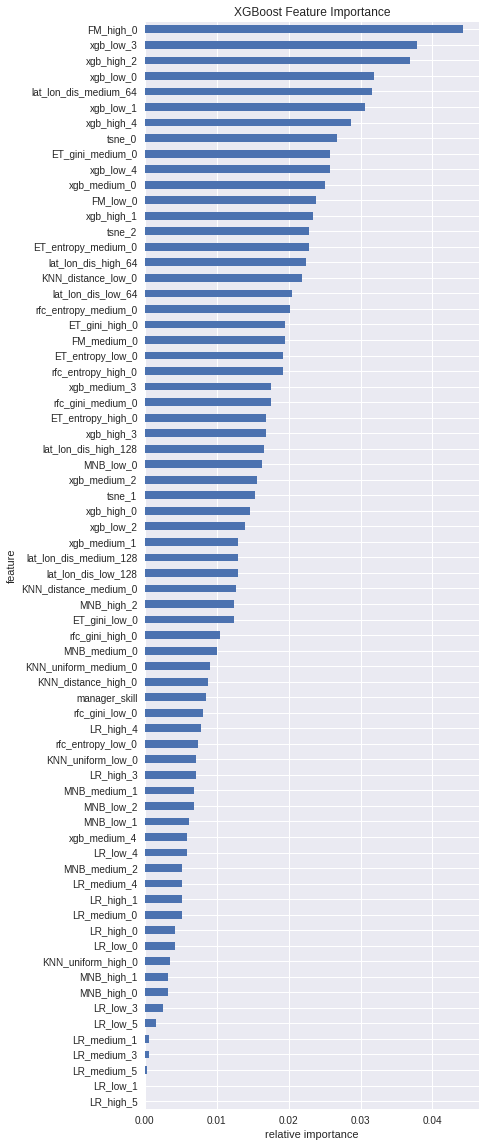

In [78]:
importance = np.vstack((these_features, rgr.feature_importances_))
f_df = pd.DataFrame(importance.T, columns=['feature', 'fscore'])

f_df = f_df.sort_values(by = 'fscore',ascending = True)
f_df.fscore = f_df.fscore.astype('float32')

f_df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 20))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

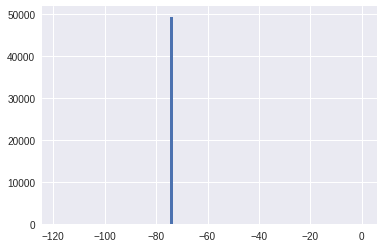

In [80]:
train_df.longitude.hist(bins = 100)

# Tune XGBoost

In [286]:
learning_rate = 0.1
best_score = 1000
train_param = 0
for x in [1,2,3,4,5,6]:
    rgr = xgb.XGBClassifier(
        objective='multi:softprob',
        seed = 1234, # use a fixed seed during tuning so we can reproduce the results
        learning_rate = learning_rate,
        n_estimators = 10000,
        max_depth= x,
        nthread = -1,
        silent = False
    )
    rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=50,
        verbose=False
    )
    
    if rgr.best_score < best_score:
        best_score = rgr.best_score
        train_param = x

    print x, '\t', rgr.best_score, rgr.best_iteration

1 	0.522657 514
2 	0.522467 169
3 	0.522598 128
4 	0.523251 99
5 	0.524396 89
6 	0.525596 66


In [126]:
for x in [1,2]:
    rgr = xgb.XGBClassifier(
        objective='multi:softprob',
        seed = 1234, # use a fixed seed during tuning so we can reproduce the results
        learning_rate = learning_rate,
        n_estimators = 10000,
        max_depth= x,
        nthread = -1,
        silent = False
    )
    rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=50,
        verbose=False
    )
    
    if rgr.best_score < best_score:
        best_score = rgr.best_score
        train_param = x

    print x, '\t', rgr.best_score, rgr.best_iteration

1 	0.522653 546
2 	0.522366 191


In [127]:
max_depth = train_param
print train_param

2


In [129]:
train_param = 1
for x in [2,4,8,16]:
    rgr = xgb.XGBClassifier(
        objective='multi:softprob',
        seed = 1234, # use a fixed seed during tuning so we can reproduce the results
        learning_rate = learning_rate,
        n_estimators = 10000,
        max_depth= max_depth,
        nthread = -1,
        silent = False,
        min_child_weight = x
    )
    rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=50,
        verbose=False
    )
    
    if rgr.best_score < best_score:
        best_score = rgr.best_score
        train_param = x
        

    print x, '\t', rgr.best_score, rgr.best_iteration

2 	0.522516 142
4 	0.52234 145
8 	0.522288 152
16 	0.522447 149


In [130]:
min_child_weight = train_param
print min_child_weight

8


In [131]:
train_param = 1
for x in [0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    rgr = xgb.XGBClassifier(
        objective='multi:softprob',
        seed = 1234, # use a fixed seed during tuning so we can reproduce the results
        learning_rate = learning_rate,
        n_estimators = 10000,
        max_depth= max_depth,
        nthread = -1,
        silent = False,
        min_child_weight = min_child_weight,
        colsample_bytree = x
    )
    rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=50,
        verbose=False
    )

    if rgr.best_score < best_score:
        best_score = rgr.best_score
        train_param = x
        

    print x, '\t', rgr.best_score, rgr.best_iteration

0.3 	0.52226 221
0.4 	0.522604 115
0.5 	0.522386 151
0.6 	0.522382 159
0.7 	0.522335 160
0.8 	0.52219 159
0.9 	0.522377 162


In [132]:
colsample_bytree = train_param
print train_param

0.8


In [133]:
train_param = 1
for x in [0.5,0.6,0.7,0.8,0.9]:
    rgr = xgb.XGBClassifier(
        objective='multi:softprob',
        seed = 1234, # use a fixed seed during tuning so we can reproduce the results
        learning_rate = learning_rate,
        n_estimators = 10000,
        max_depth= max_depth,
        nthread = -1,
        silent = False,
        min_child_weight = min_child_weight,
        colsample_bytree = colsample_bytree,
        subsample = x
    )
    rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=50,
        verbose=False
    )
    if rgr.best_score < best_score:
        best_score = rgr.best_score
        train_param = x
        

    print x, '\t', rgr.best_score, rgr.best_iteration

0.5 	0.522391 106
0.6 	0.522022 114
0.7 	0.521796 155
0.8 	0.522082 156
0.9 	0.522189 137


In [134]:
subsample = train_param
print train_param

0.7


In [135]:
train_param = 0
for x in [0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0]:
    rgr = xgb.XGBClassifier(
        objective='multi:softprob',
        seed = 1234, # use a fixed seed during tuning so we can reproduce the results
        learning_rate = learning_rate,
        n_estimators = 10000,
        max_depth= max_depth,
        nthread = -1,
        silent = False,
        min_child_weight = min_child_weight,
        colsample_bytree = colsample_bytree,
        subsample = subsample,
        gamma = x
    )
    rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=50,
        verbose=False
    )

    if rgr.best_score < best_score:
        best_score = rgr.best_score
        train_param = x
        

    print x, '\t', rgr.best_score, rgr.best_iteration

0.3 	0.521587 229
0.6 	0.521889 155
0.9 	0.521672 229
1.2 	0.521809 185
1.5 	0.521477 229
1.8 	0.521727 155
2.1 	0.521937 155
2.4 	0.521896 155
2.7 	0.521784 227
3.0 	0.522045 155


In [136]:
gamma = train_param
print gamma

1.5


In [137]:
rgr = xgb.XGBClassifier(
    objective='multi:softprob',
    seed = 1234, # use a fixed seed during tuning so we can reproduce the results
    learning_rate = learning_rate,
    n_estimators = 10000,
    max_depth= max_depth,
    nthread = -1,
    silent = False,
    min_child_weight = min_child_weight,
    colsample_bytree = colsample_bytree,
    subsample = subsample,
    gamma = gamma
)
rgr.fit(X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
#         num_class = 3,
        early_stopping_rounds=50,
        verbose=25
       )

[0]	validation_0-mlogloss:1.02329
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[25]	validation_0-mlogloss:0.553328
[50]	validation_0-mlogloss:0.526073
[75]	validation_0-mlogloss:0.522986
[100]	validation_0-mlogloss:0.522024
[125]	validation_0-mlogloss:0.521917
[150]	validation_0-mlogloss:0.521824
[175]	validation_0-mlogloss:0.521716
[200]	validation_0-mlogloss:0.521808
[225]	validation_0-mlogloss:0.521579
[250]	validation_0-mlogloss:0.521706
[275]	validation_0-mlogloss:0.521784
Stopping. Best iteration:
[229]	validation_0-mlogloss:0.521477



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=1.5, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=8, missing=None, n_estimators=10000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=False, subsample=0.7)

In [138]:
pred_y = rgr.predict_proba(test_2nd_mean, ntree_limit = rgr.best_iteration)
test_df = pd.read_csv('../input/' + 'test_BrandenMurray.csv')

now = datetime.now()
sub_name = '../output/sub_xgb_2nd_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'

out_df = pd.DataFrame(pred_y[:,:3])
out_df.columns = ["low", "medium", "high"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv(sub_name, index=False)